In [1]:
"""
Multi-Modal Feature Extraction & Visualization Script

Supports three feature types:
  1. Handcrafted statistical/topological features
  2. VGG16 convolutional features (Keras)
  3. ResNet50 deep features (PyTorch)

For each dataset:
  - Loads raw images (or existing feature files)
  - Extracts or loads features
  - Saves features to disk (CSV for handcrafted, NPZ for deep)

Visualization:
  - Handcrafted: density‐normalized histograms (pairwise and all datasets)
  - Deep (VGG16/ResNet): per‐dataset PCA scatter + combined TSNE scatter

Usage:
  python script.py --feature_type {handcrafted,vgg16,resnet} [--load_existing] [--real REAL] [--synth SYNTH]
"""

'\nMulti-Modal Feature Extraction & Visualization Script\n\nSupports three feature types:\n  1. Handcrafted statistical/topological features\n  2. VGG16 convolutional features (Keras)\n  3. ResNet50 deep features (PyTorch)\n\nFor each dataset:\n  - Loads raw images (or existing feature files)\n  - Extracts or loads features\n  - Saves features to disk (CSV for handcrafted, NPZ for deep)\n\nVisualization:\n  - Handcrafted: density‐normalized histograms (pairwise and all datasets)\n  - Deep (VGG16/ResNet): per‐dataset PCA scatter + combined TSNE scatter\n\nUsage:\n  python script.py --feature_type {handcrafted,vgg16,resnet} [--load_existing] [--real REAL] [--synth SYNTH]\n'

In [ ]:
# --------------------------------------------------------------------------------
# Interactive Feature Extraction & Visualization Script
#--------------------------------------------------------------------------------
"""
Loads images or existing feature files, extracts features (handcrafted, VGG16, or ResNet50),
saves them per dataset, and provides dataset-aware visualizations.
Interactive prompts replace command-line arguments for notebook use.
"""

# --- 1. Imports ----------------------------------------------------------------
import os
from pathlib import Path
from typing import Dict, List, Tuple
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from PIL import Image
from skimage import feature
from gudhi import CubicalComplex



# Deep models
from keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image as kimage
import torch
import torch.nn as nn
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader

# Embedding
from sklearn.decomposition import PCA
from openTSNE import TSNE as oTSNE

In [ ]:
# --- 2. Configuration ---------------------------------------------------------
# VinDr, DDSM, and InBreast are patient data
# MSYNTH, HuggingFace, and Medigan are synthetic data

DATASETS: Dict[str, str] = {

    'VinDr':       'cropped_sampled_vindr-mammo_images/cropped_sampled_vindr-mammo_images_resized/center_cropped/equalized_images',
    'DDSM':        'DDSM_all_images_cropped/DDSM_images_resized/DDSM_all_clean_all/center_cropped/equalized_images',
    'InBreast':    'INbreast_cropped_DICOM_images/INbreast_cropped_DICOM_images_resized/center_cropped/equalized_images',
    'MIAS':        'all-mias_cropped_images/all-mias_cropped_images_resized/center_cropped_clean_all_mias/equalized_images',
    'MSYNTH':      'All_images_Elena/Elena_images_resized/equalized_images',
    'HuggingFace': 'HF_synthetic_mammography_csaw/center_cropped',
    'Mammo_medigan':'Mammo_medigan/medigan_images_resized/center_cropped'
}
IMAGE_EXTS = {'.jpg','.jpeg','.png','.tif','.tiff','.dicom','.dcm'}
SAVE_DIR = Path('./features_output')
(SAVE_DIR/'handcrafted').mkdir(parents=True, exist_ok=True)
(SAVE_DIR/'vgg16').mkdir(parents=True, exist_ok=True)
(SAVE_DIR/'resnet').mkdir(parents=True, exist_ok=True)



HANDCRAFTED_COLS = ['mean','std','skew','kurt','median',
                    'edge_density','avg_edge_intensity',
                    'low_freq_energy','high_freq_energy',
                    'betti_0','betti_1']
IMG_SIZE_VGG = (512,512)
IMG_SIZE_RES = (224,224)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# --- 3. Feature Extraction Functions -----------------------------------------
def compute_handcrafted(arr: np.ndarray) -> np.ndarray:
    flat = arr.flatten(); m, s = flat.mean(), flat.std()
    sk = stats.skew(flat); kt = stats.kurtosis(flat); md = np.median(flat)
    edges = feature.canny(arr); ed_den = edges.mean()
    ed_int = arr[edges].mean() if edges.any() else 0.0
    fshift = np.fft.fftshift(np.fft.fft2(arr)); mag = np.abs(fshift)
    lf, hf = mag[:10,:10].sum(), mag[-10:,-10:].sum()
    flat_cells = arr.flatten()
    cc = CubicalComplex(dimensions=arr.shape, top_dimensional_cells=flat_cells)
    pers = cc.persistence(); b0 = sum(d==0 for d,_ in pers)
    b1 = sum(d==1 for d,_ in pers)
    return np.array([m,s,sk,kt,md, ed_den,ed_int, lf,hf, b0,b1])

_vgg_model=None
def extract_vgg16_features(img_path:Path)->np.ndarray:
    global _vgg_model
    if _vgg_model is None:
        _vgg_model = VGG16(weights='imagenet', include_top=False)
    img = kimage.load_img(str(img_path), target_size=IMG_SIZE_VGG)
    arr = kimage.img_to_array(img); arr=np.expand_dims(arr,0)
    arr=preprocess_input(arr); feats=_vgg_model.predict(arr)
    return feats.flatten()

_res_model=None
class ImgDS(Dataset):
    def __init__(self,paths,trans): self.paths, self.trans = paths, trans
    def __len__(self): return len(self.paths)
    def __getitem__(self,i):
        x=Image.open(self.paths[i]).convert('RGB')
        return self.trans(x), self.paths[i]

def extract_resnet_features(img_tensor, model)->np.ndarray:
    return model(img_tensor).view(img_tensor.size(0),-1).cpu().numpy()

In [ ]:
# --- 4. Interactive Workflow --------------------------------------------------
# 4.1: Choose feature type
ft = input("Select feature type (handcrafted, vgg16, resnet): ").strip().lower()
assert ft in {'handcrafted','vgg16','resnet'}
le = input("Load existing features if available? (y/n): ").strip().lower()=='y'

# Dictionaries to hold results
hc_dfs, deep_feats = {}, {}


In [ ]:
# 4.2: Process each dataset
for name, path in DATASETS.items():
    print(f"\n=== Dataset: {name} ===")
    if ft=='handcrafted':
        out_csv = SAVE_DIR/'handcrafted'/f"{name}_handcrafted.csv"
        if le and out_csv.exists():
            hc_dfs[name]=pd.read_csv(out_csv)
            print(f"Loaded existing handcrafted for {name}")
        else:
            imgs=[p for p in Path(path).rglob('*') if p.suffix.lower() in IMAGE_EXTS]
            arrs=[compute_handcrafted(np.array(Image.open(p).convert('L'))) for p in tqdm(imgs)]
            df=pd.DataFrame(arrs,columns=HANDCRAFTED_COLS)
            df.to_csv(out_csv,index=False)
            hc_dfs[name]=df
    else:
        dir_ = SAVE_DIR/('vgg16' if ft=='vgg16' else 'resnet')
        ext = 'vgg16' if ft=='vgg16' else 'resnet'
        file_npz = dir_/f"{name}_{ext}.npz"
        if le and file_npz.exists():
            data=np.load(file_npz,allow_pickle=True)
            deep_feats[name]=data['features']
            print(f"Loaded existing deep ({ext}) for {name}")
        else:
            imgs=[p for p in Path(path).rglob('*') if p.suffix.lower() in IMAGE_EXTS]
            if ft=='vgg16':
                feats=[extract_vgg16_features(p) for p in tqdm(imgs)]
            else:
                if _res_model is None:
                    r=models.resnet50(pretrained=True)
                    _res_model=nn.Sequential(*list(r.children())[:-1]).to(DEVICE).eval()
                trans=transforms.Compose([
                    transforms.Resize(IMG_SIZE_RES),transforms.ToTensor(),
                    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
                ])
                ds=ImgDS([str(p) for p in imgs],trans)
                loader=DataLoader(ds,batch_size=32,shuffle=False,num_workers=2)
                feats=[]
                for batch,paths in tqdm(loader):
                    feats.append(extract_resnet_features(batch.to(DEVICE),_res_model))
                feats=np.vstack(feats)
            np.savez_compressed(file_npz,features=feats)
            deep_feats[name]=feats


Select feature type (handcrafted, vgg16, resnet): handcrafted
Load existing features if available? (y/n): n

=== Dataset: VinDr ===


100%|██████████| 9001/9001 [4:30:42<00:00,  1.80s/it]



=== Dataset: DDSM ===


0it [00:00, ?it/s]



=== Dataset: InBreast ===


100%|██████████| 411/411 [06:12<00:00,  1.10it/s]



=== Dataset: MIAS ===


100%|██████████| 322/322 [04:41<00:00,  1.14it/s]



=== Dataset: MSYNTH ===


100%|██████████| 163/163 [02:43<00:00,  1.00s/it]



=== Dataset: HuggingFace ===


0it [00:00, ?it/s]



=== Dataset: Mammo_medigan ===


100%|██████████| 4285/4285 [40:10<00:00,  1.78it/s]


Enter real dataset key for comparison: MIAS
Enter synthetic dataset key: Mammo_medigan


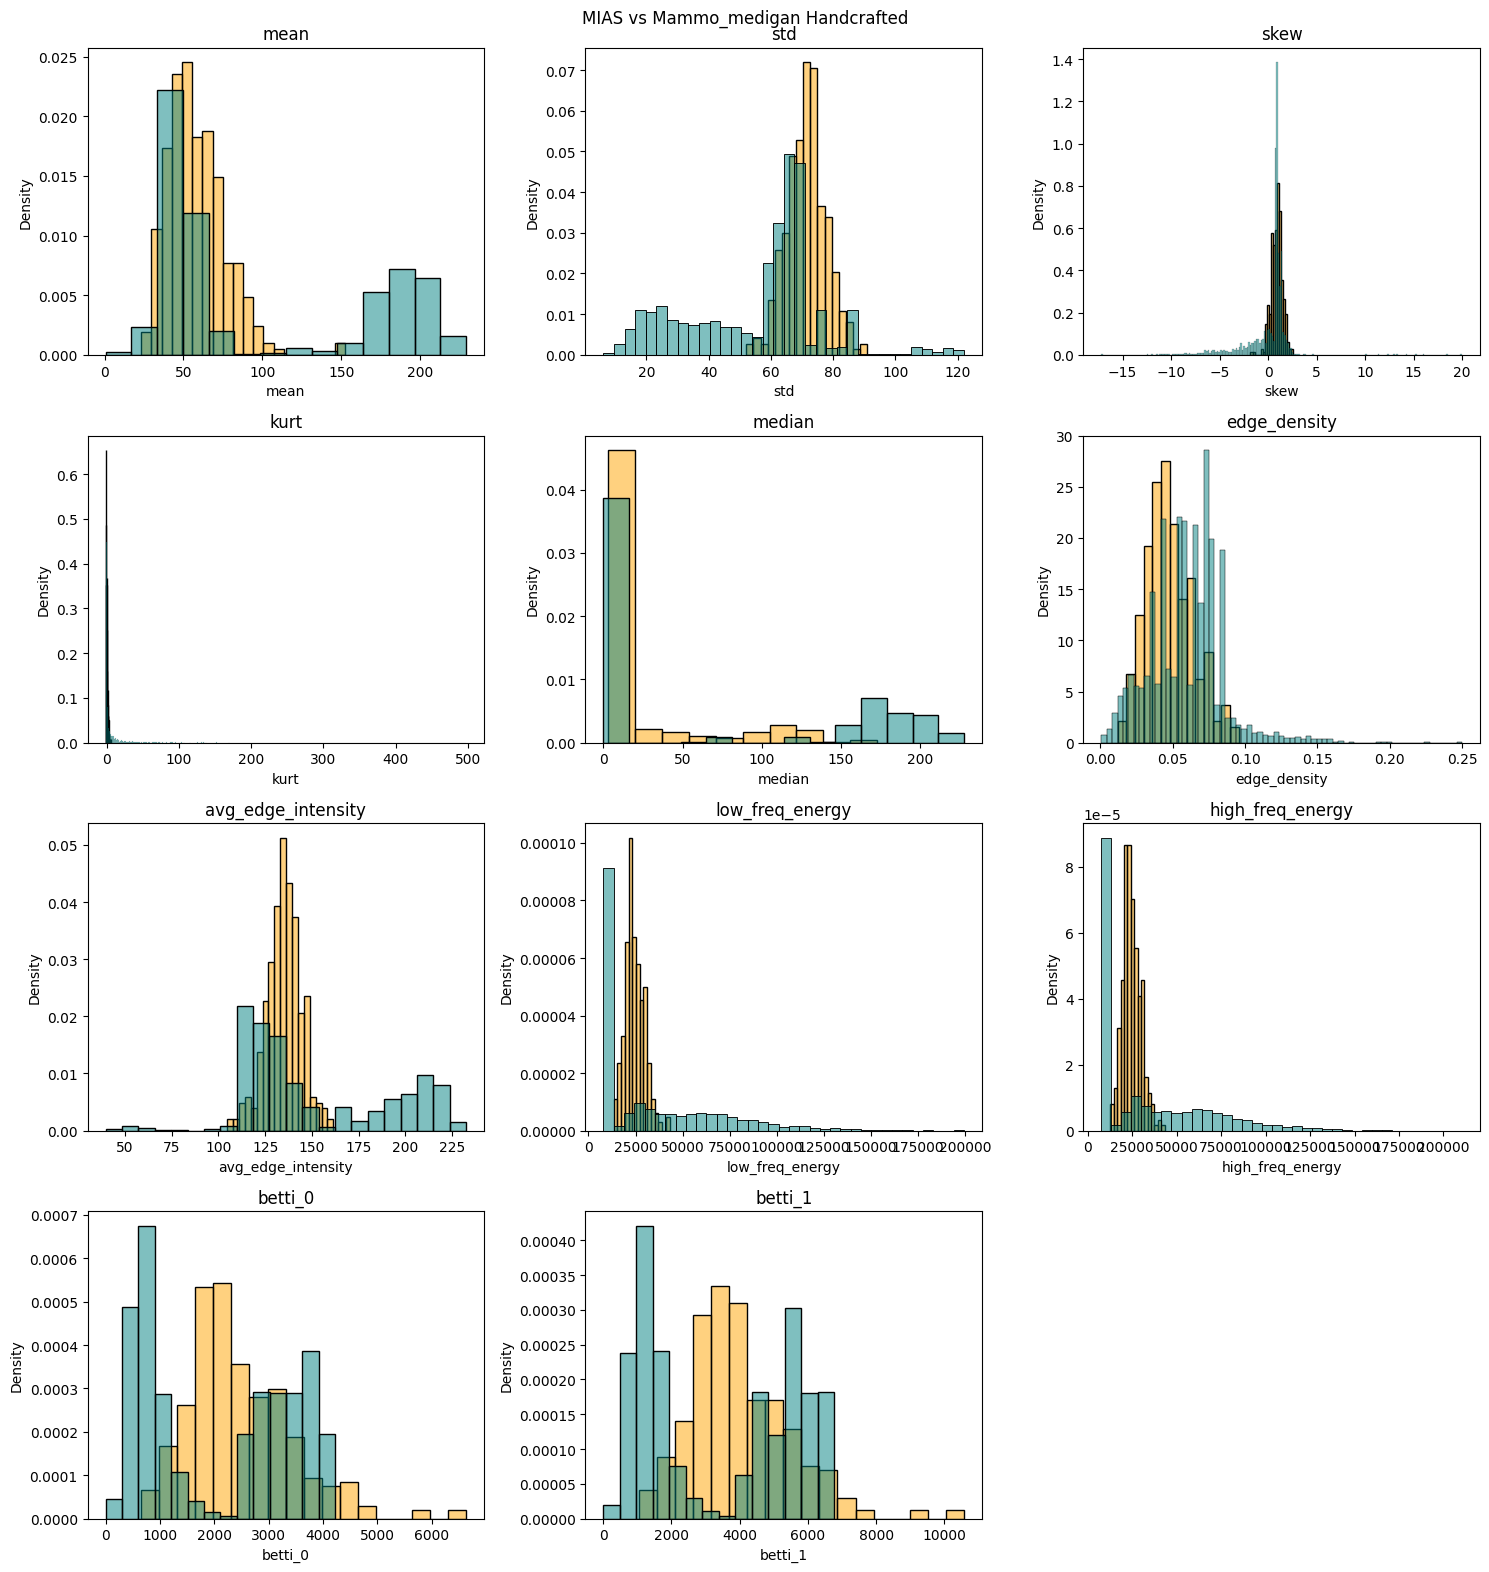

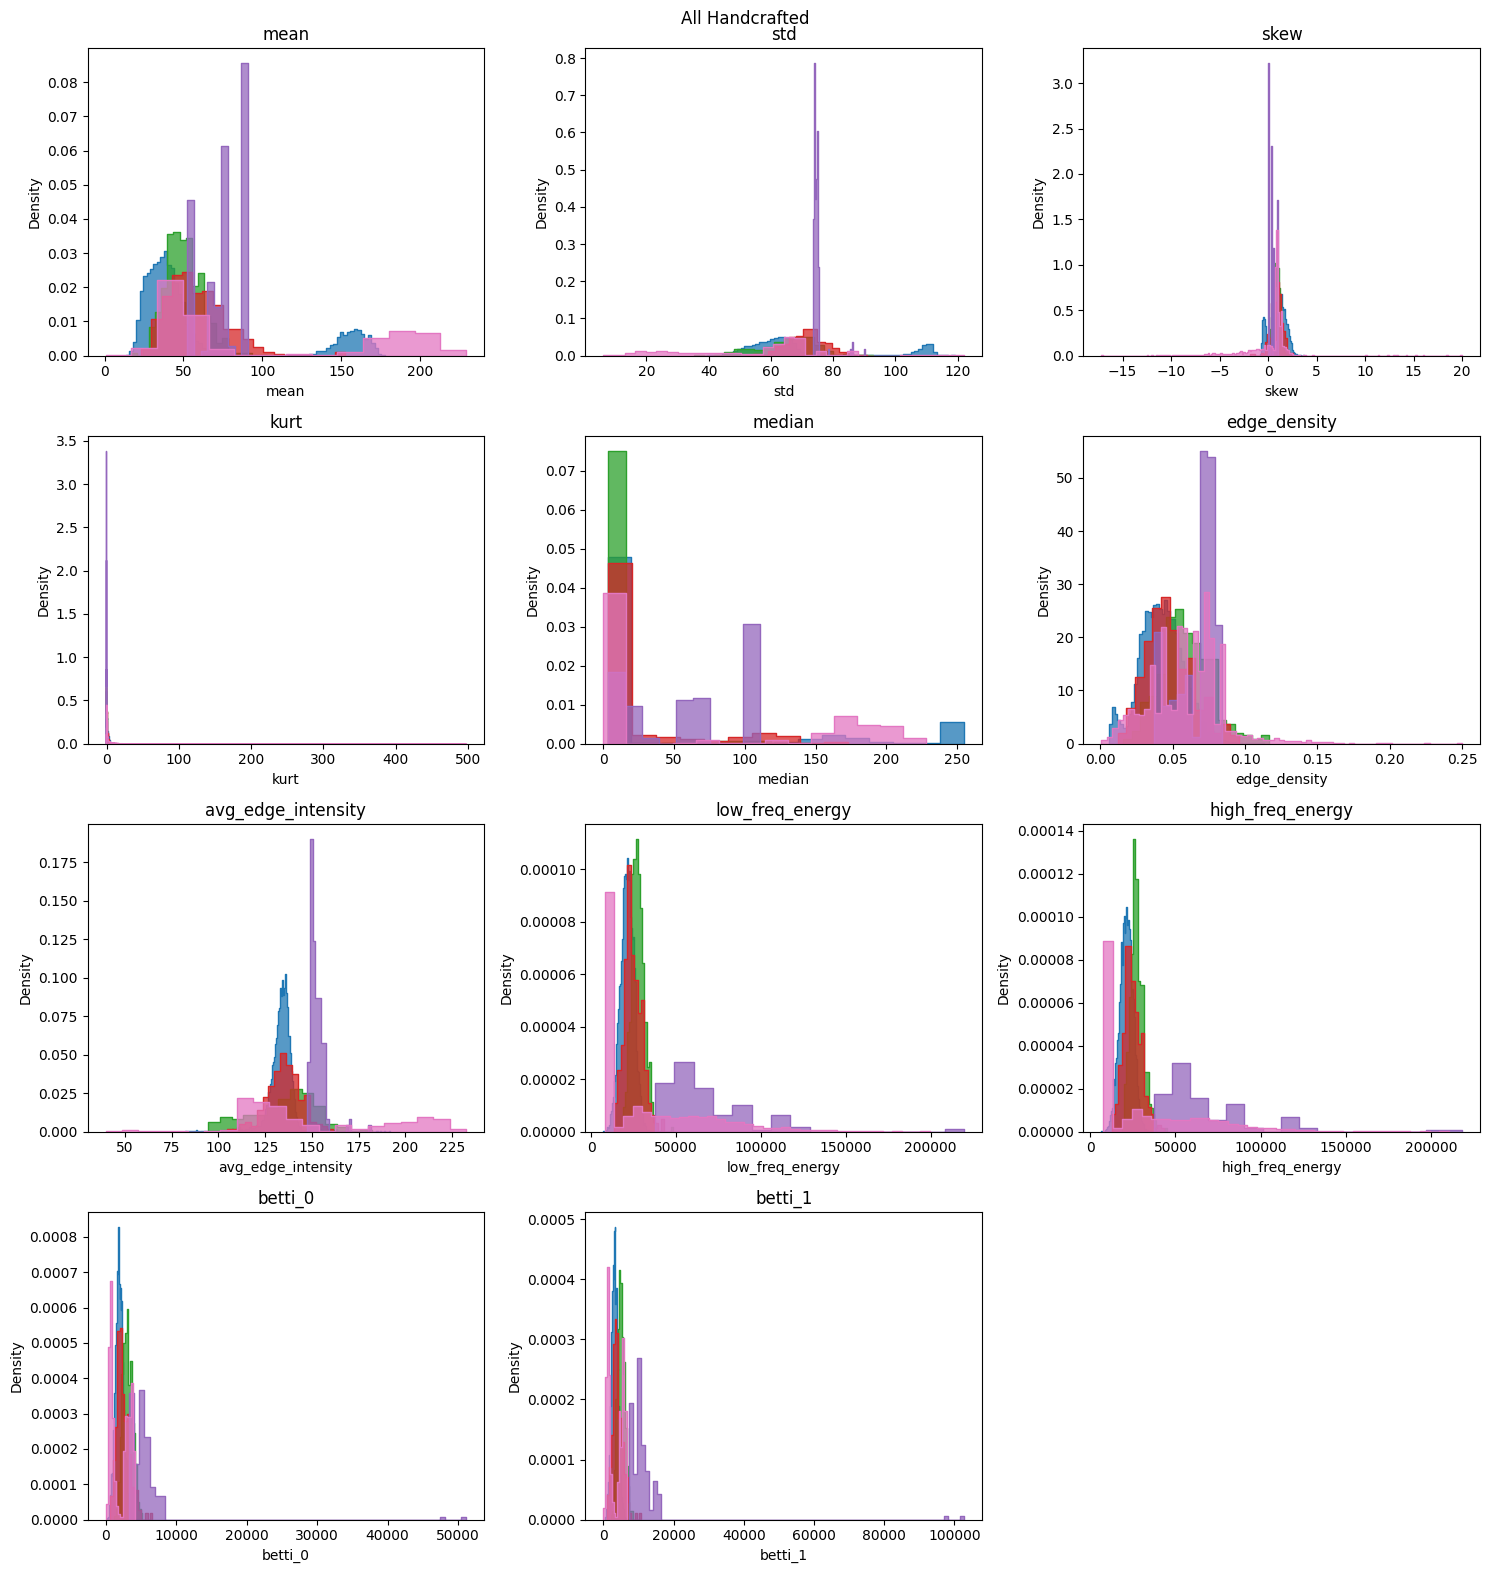

In [18]:
# --- 5. Visualization ---------------------------------------------------------
if ft=='handcrafted':
    r = input("Enter real dataset key for comparison: ")
    s = input("Enter synthetic dataset key: ")
    # pairwise
    n1,n2=len(hc_dfs[r]),len(hc_dfs[s])
    F=len(HANDCRAFTED_COLS);
    cols=3; rows=(F+2)//3
    fig,axes=plt.subplots(rows,cols,figsize=(5*cols,4*rows))
    axes=axes.flatten()
    for i,c in enumerate(HANDCRAFTED_COLS):
        ax=axes[i]
        sns.histplot(hc_dfs[r][c],stat='density',label=f'{r}(n={n1})',color='orange',alpha=0.5,ax=ax)
        sns.histplot(hc_dfs[s][c],stat='density',label=f'{s}(n={n2})',color='teal',alpha=0.5,ax=ax)
        ax.set_title(c)
    for j in range(F,len(axes)): fig.delaxes(axes[j])
    fig.suptitle(f'{r} vs {s} Handcrafted'); plt.tight_layout(); plt.show()
    # all
    fig,axes=plt.subplots(rows,cols,figsize=(5*cols,4*rows));axes=axes.flatten()
    for i,c in enumerate(HANDCRAFTED_COLS):
        ax=axes[i]
        for name,df in hc_dfs.items(): sns.histplot(df[c],stat='density',label=f'{name}(n={len(df)})',element='step',ax=ax)
        ax.set_title(c)
    for j in range(F,len(axes)): fig.delaxes(axes[j])
    fig.suptitle('All Handcrafted'); plt.tight_layout(); plt.show()
else:
    # per dataset PCA
    for name, arr in deep_feats.items():
        emb=PCA(2).fit_transform(arr)
        plt.figure(figsize=(5,5)); plt.scatter(emb[:,0],emb[:,1],s=5)
        plt.title(f'{name} PCA'); plt.show()
    # combined TSNE
    X=np.vstack(list(deep_feats.values()))
    labels=[n for n,arr in deep_feats.items() for _ in range(len(arr))]
    tsne=oTSNE(n_components=2,random_state=42).fit(X)
    plt.figure(figsize=(7,5))
    for ds in sorted(deep_feats):
        idx=[i for i,l in enumerate(labels) if l==ds]
        plt.scatter(tsne[idx,0],tsne[idx,1],label=ds,s=5)
    plt.legend(); plt.title('Combined TSNE'); plt.show()
